In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import matplotlib.pyplot as plt
import random

def load_images(image_folder):
    images = []
    for image_file in sorted(os.listdir(image_folder)):
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            image_path = os.path.join(image_folder, image_file)
            image = Image.open(image_path).convert('L')
            image = image.resize((256, 256))  # Resize images to a fixed size
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
    return np.array(images)

def create_dataset(downloaded_images_dir, cleaned_images_dir, condition_dir):
    downloaded_images = load_images(downloaded_images_dir)
    cleaned_images = load_images(cleaned_images_dir)
    condition_images = load_images(condition_dir)
    
    X_combined = np.stack((downloaded_images, condition_images), axis=-1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_combined, cleaned_images, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Directories
downloaded_images_dir = 'downloaded_images'
cleaned_images_dir = 'cleaned_images'
condition_dir = 'condition'

# Create dataset
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(downloaded_images_dir, cleaned_images_dir, condition_dir)

# Reshape data to add channel dimension for target
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

2024-07-25 11:19:20.603183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 11:19:20.624814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 11:19:20.631705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 11:19:20.650220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def combined_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    mse = MeanSquaredError()(y_true, y_pred)
    return bce + 0.01 * mse

def unet_model(input_size=(256, 256, 2)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs, conv9)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss, metrics=['accuracy'])
    
    return model

# Initialize and train the model
model = unet_model()

2024-07-25 11:19:52.265376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22066 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:42:00.0, compute capability: 8.9


In [3]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val))

Epoch 1/50


I0000 00:00:1721906410.452703   18472 service.cc:146] XLA service 0x714fec0045c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721906410.452763   18472 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-25 11:20:10.603625: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 11:20:11.298909: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


   9/2868 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9572 - loss: 0.6040 

I0000 00:00:1721906416.669306   18472 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2868/2868 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - accuracy: 0.9668 - loss: 0.0606 - val_accuracy: 0.9696 - val_loss: 0.0324
Epoch 2/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.9712 - loss: 0.0281 - val_accuracy: 0.9717 - val_loss: 0.0236
Epoch 3/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9725 - loss: 0.0227 - val_accuracy: 0.9725 - val_loss: 0.0218
Epoch 4/50
2037/2868 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9727 - loss: 0.0214

KeyboardInterrupt: 

2024-07-25 11:22:56.062750: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-25 11:22:56.874028: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

2024-07-25 11:23:05.740825: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-25 11:23:06.600285: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 19.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step


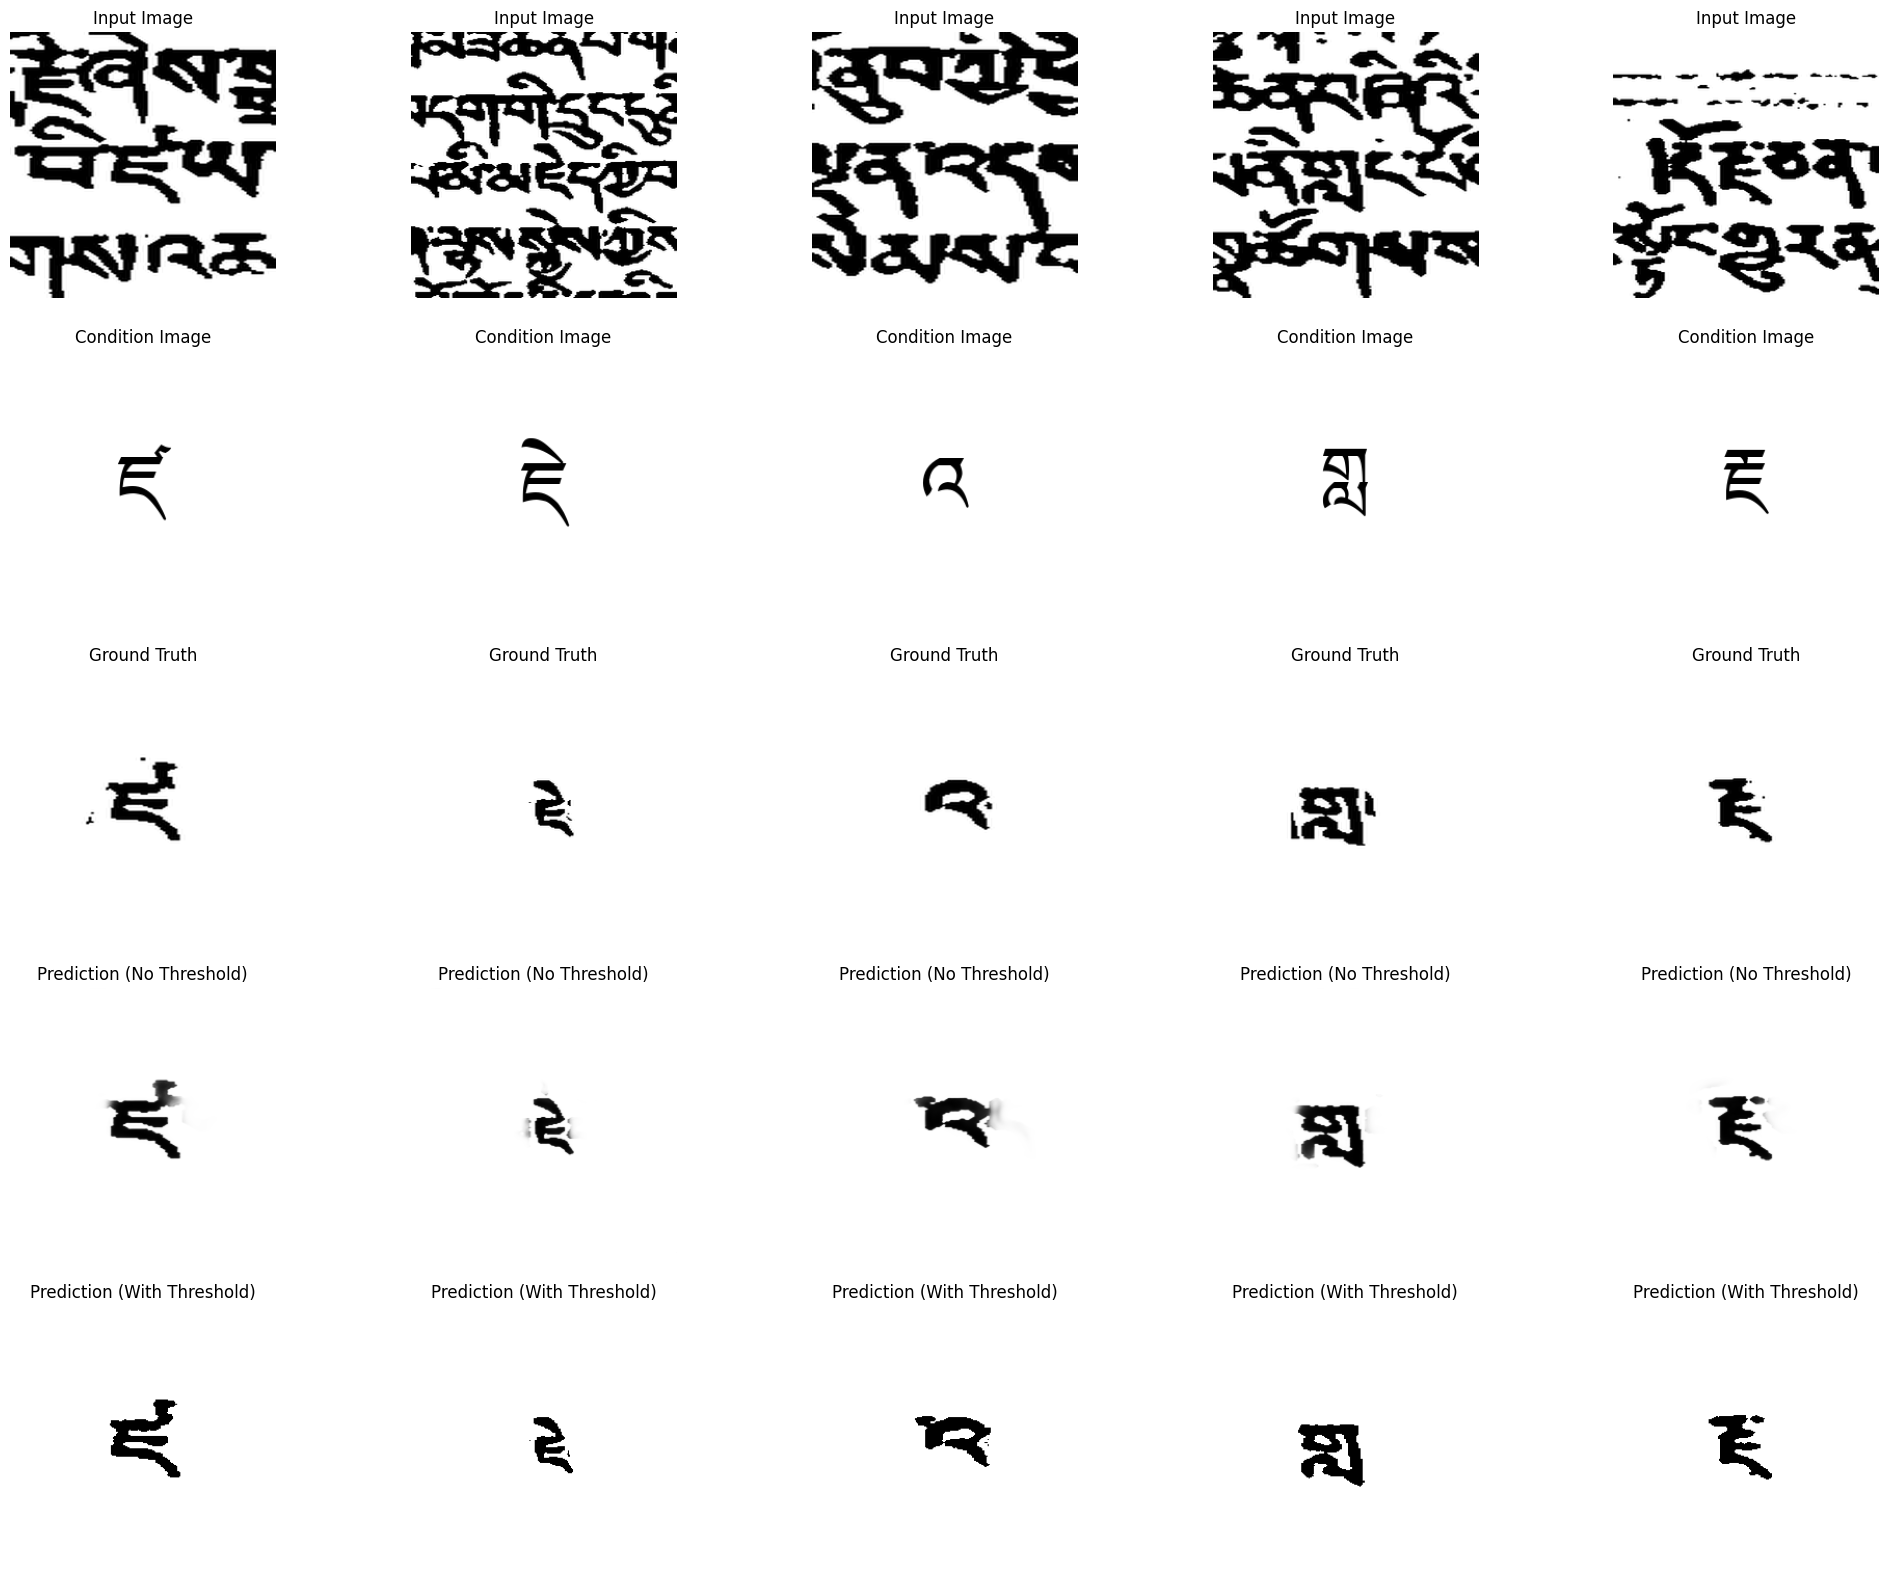

In [4]:
def apply_threshold(image, threshold=0.5):
    return (image > threshold).astype(np.float32)

def display_sample_predictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    n_samples = 5
    plt.figure(figsize=(25, 20))
    for i in range(n_samples):
        idx = random.randint(0, len(X_test) - 1)
        
        plt.subplot(5, n_samples, i + 1)
        plt.title("Input Image")
        plt.imshow(X_test[idx, :, :, 0], cmap='gray')  # Show the dirty image part
        plt.axis('off')
        
        plt.subplot(5, n_samples, i + n_samples + 1)
        plt.title("Condition Image")
        plt.imshow(X_test[idx, :, :, 1], cmap='gray')  # Show the glyph image part
        plt.axis('off')

        plt.subplot(5, n_samples, i + 2 * n_samples + 1)
        plt.title("Ground Truth")
        plt.imshow(y_test[idx].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(5, n_samples, i + 3 * n_samples + 1)
        plt.title("Prediction (No Threshold)")
        plt.imshow(predictions[idx].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(5, n_samples, i + 4 * n_samples + 1)
        plt.title("Prediction (With Threshold)")
        plt.imshow(apply_threshold(predictions[idx]).squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Display sample predictions
display_sample_predictions(model, X_test, y_test)